In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for displaying the audio
from IPython.display import Audio

# for loading the audio file
import librosa
import librosa.display
import random


from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/5322/')

# Accessing Audio Files

## Audio File 1 - amecro

In [ ]:
audio_recording="original_clips/amecro/XC304860.mp3"
data,rate=librosa.load(audio_recording)
print(type(data),type(rate))

<class 'numpy.ndarray'> <class 'int'>


In [ ]:
print(f"Sample Rate: {rate} Hz ")
print(f"Number of Samples : {data.shape[0]}")
length = data.shape[0] / rate
print("Length of the audio file is {:.2f} seconds".format(length))

Sample Rate: 22050 Hz 
Number of Samples : 78336
Length of the audio file is 3.55 seconds


In [ ]:
Audio(data,rate=rate)

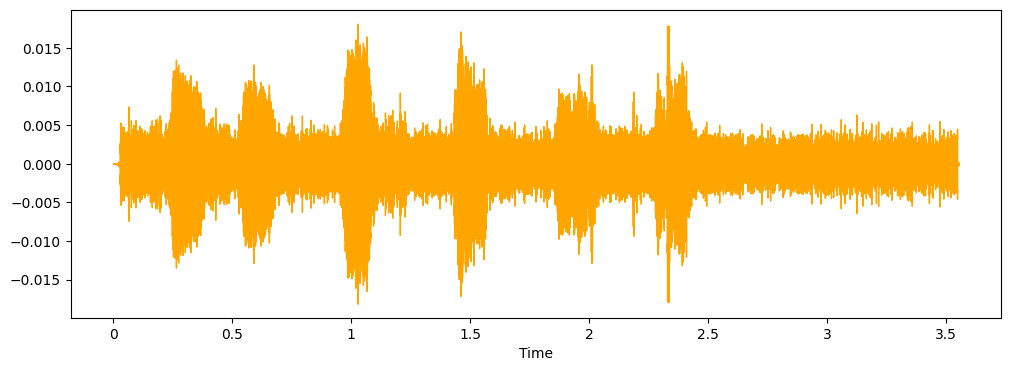

In [ ]:
plt.figure(figsize=(12,4))
librosa.display.waveshow(data,color="orange")
plt.show()

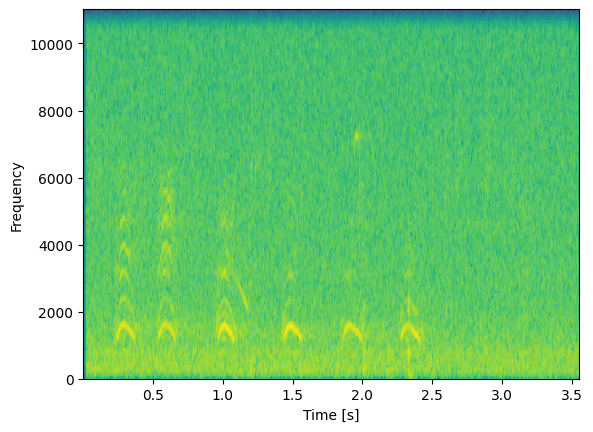

In [ ]:
plt.specgram(data, Fs=rate)
plt.xlabel("Time [s]")
plt.ylabel("Frequency");

## Audio File 2 - norfli

In [ ]:
audio_recording="original_clips/norfli/XC57036.mp3"
data,rate=librosa.load(audio_recording)
print(type(data),type(rate))

<class 'numpy.ndarray'> <class 'int'>


In [ ]:
print(f"Sample Rate: {rate} Hz ")
print(f"Number of Samples : {data.shape[0]}")
length = data.shape[0] / rate
print("Length of the audio file is {:.2f} seconds".format(length))

Sample Rate: 22050 Hz 
Number of Samples : 360000
Length of the audio file is 16.33 seconds


In [ ]:
Audio(data,rate=rate)

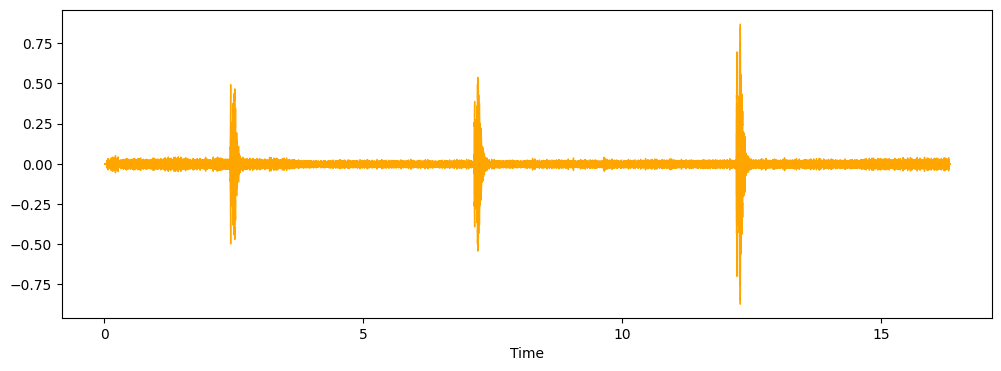

In [ ]:
plt.figure(figsize=(12,4))
librosa.display.waveshow(data,color="orange")
plt.show()

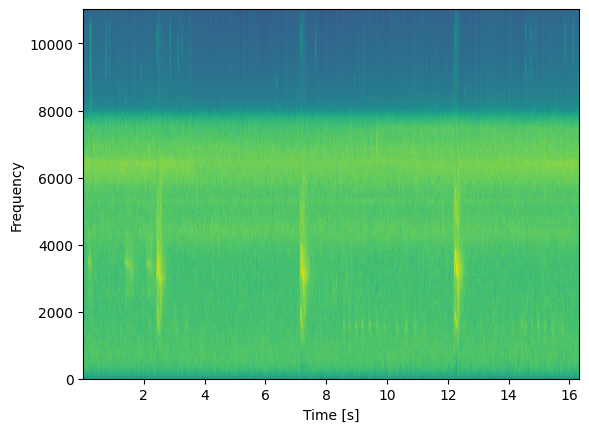

In [ ]:
#@title
plt.specgram(data, Fs=rate)
plt.xlabel("Time [s]")
plt.ylabel("Frequency");

# BINARY CLASSIFICATION
**Amecro VS Norfli**

## Data Preprocessing

In [ ]:
# Define the folder path where the bird audio files are stored
folder_path = 'original_clips/'
# Define the new sample rate to which the audio will be resampled
new_sample_rate = 22050
# Define the minimum length (in seconds) of a "loud" part of the sound clip
min_loud_part_length = 0.5
# Define the window size (in seconds) for selecting bird calls
bird_call_window_size = 2
# Define the spectrogram parameters
n_fft = 2048
hop_length = 512
# Initialize the lists for storing the spectrograms and bird names
audios = []
labels = []
# Loop through each bird folder
for bird_folder in os.listdir(folder_path):
  if bird_folder == 'amecro' or bird_folder == 'norfli':
    # Get the full path of the bird folder
    bird_folder_path = os.path.join(folder_path, bird_folder)
    for audio_file in os.listdir(bird_folder_path):
      # Get the full path of the audio file
      audio_file_path = os.path.join(bird_folder_path, audio_file)
      # Load the audio file and resample to the new sample rate
      y, sr = librosa.load(audio_file_path, sr=new_sample_rate)
      # Compute the energy of the audio signal
      energy = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)
      # Find the indexes of the "loud" parts of the sound clip
      loud_indexes = np.where(energy > np.max(energy)*0.5)[1]
      # Loop through each "loud" part of the sound clip
      for loud_idx in loud_indexes:
        # Compute the start and end times of the bird call window
        start_time = loud_idx*hop_length/sr
        end_time = start_time + bird_call_window_size
        # Extract the audio signal within the bird call window
        bird_call_audio = y[int(start_time*sr):int(end_time*sr)]
        # Compute the spectrogram of the bird call audio
        spectrogram = librosa.feature.melspectrogram(y=bird_call_audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
        # Add the spectrogram to the list of audios
        audios.append(spectrogram)
        # Add the bird name to the list of labels
        labels.append(bird_folder)
      # Uncomment the following lines to display the spectrograms
      # plt.figure(figsize=(10, 4))
      # librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), y_axis='mel', x_axis='time')
      # plt.colorbar(format='%+2.0f dB')
      # plt.title('Mel spectrogram')
      # plt.tight_layout()
      # plt.show()

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1655
  warnings.warn(


In [ ]:
# Pad the spectrograms with zeros to ensure they all have the same shape
max_length = max([s.shape[1] for s in audios])
padded_audios = []
for s in audios:
  pad_width = max_length - s.shape[1]
  s_padded = np.pad(s, pad_width=((0, 0), (0, pad_width)), mode='constant')
  padded_audios.append(s_padded)

# Convert the padded audios to a numpy array
audios = np.array(padded_audios)

# Prepare the labels
label_map = {bird_species: i for i, bird_species in enumerate(np.unique(labels))}
labels = np.array([label_map[label] for label in labels])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(audios, labels, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(952, 128, 87) (239, 128, 87) (952,) (239,)


## Model1

Epoch 1/10
30/30 [==============================] - 21s 573ms/step - loss: 0.3252 - accuracy: 0.9685 - val_loss: 1.9427 - val_accuracy: 0.9791
Epoch 2/10
30/30 [==============================] - 16s 526ms/step - loss: 0.1161 - accuracy: 0.9863 - val_loss: 0.0196 - val_accuracy: 0.9916
Epoch 3/10
30/30 [==============================] - 16s 520ms/step - loss: 0.0244 - accuracy: 0.9916 - val_loss: 0.0258 - val_accuracy: 0.9874
Epoch 4/10
30/30 [==============================] - 15s 504ms/step - loss: 0.0180 - accuracy: 0.9947 - val_loss: 0.0146 - val_accuracy: 0.9958
Epoch 5/10
30/30 [==============================] - 15s 507ms/step - loss: 0.0127 - accuracy: 0.9979 - val_loss: 0.0110 - val_accuracy: 0.9958
Epoch 6/10
30/30 [==============================] - 16s 547ms/step - loss: 0.0107 - accuracy: 0.9968 - val_loss: 0.0104 - val_accuracy: 1.0000
Epoch 7/10
30/30 [==============================] - 16s 534ms/step - loss: 0.0110 - accuracy: 0.9968 - val_loss: 0.0085 - val_accuracy: 1.0000

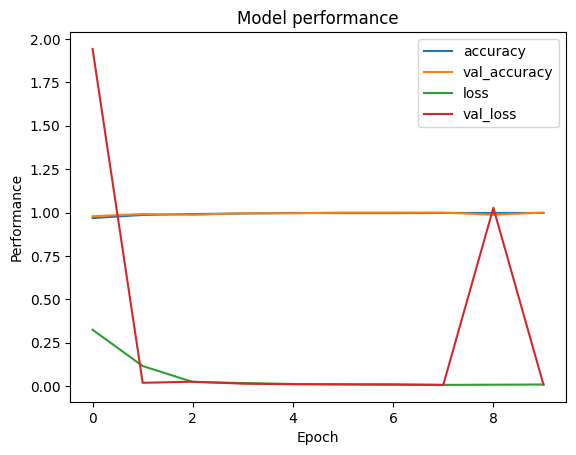

In [ ]:
# Set the seed for reproducibility
np.random.seed(123)
tf.random.set_seed(123)

b1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128,87,1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

b1.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

# Train the model and store the history
history = b1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

# Plot the accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model performance')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.legend()
plt.show()

In [ ]:
train_loss, train_acc = b1.evaluate(X_train, y_train)
print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

30/30 [==============================] - 3s 94ms/step - loss: 0.0199 - accuracy: 0.9968
Train loss: 0.019909529015421867, Train accuracy: 0.9968487620353699


In [ ]:
test_loss, test_acc = b1.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

8/8 [==============================] - 1s 91ms/step - loss: 0.0088 - accuracy: 1.0000
Test loss: 0.008771529421210289, Test accuracy: 1.0


## Model 2
Adding dropout

Epoch 1/10
30/30 [==============================] - 22s 702ms/step - loss: 0.2491 - accuracy: 0.9485 - val_loss: 0.8858 - val_accuracy: 0.9791
Epoch 2/10
30/30 [==============================] - 20s 664ms/step - loss: 0.0924 - accuracy: 0.9853 - val_loss: 0.0330 - val_accuracy: 0.9916
Epoch 3/10
30/30 [==============================] - 18s 605ms/step - loss: 0.0296 - accuracy: 0.9916 - val_loss: 0.0966 - val_accuracy: 0.9833
Epoch 4/10
30/30 [==============================] - 20s 648ms/step - loss: 0.0527 - accuracy: 0.9905 - val_loss: 0.0239 - val_accuracy: 0.9958
Epoch 5/10
30/30 [==============================] - 18s 597ms/step - loss: 0.0579 - accuracy: 0.9905 - val_loss: 0.2607 - val_accuracy: 0.9833
Epoch 6/10
30/30 [==============================] - 18s 601ms/step - loss: 0.0246 - accuracy: 0.9926 - val_loss: 0.0231 - val_accuracy: 0.9958
Epoch 7/10
30/30 [==============================] - 19s 649ms/step - loss: 0.0232 - accuracy: 0.9926 - val_loss: 0.0146 - val_accuracy: 0.9958

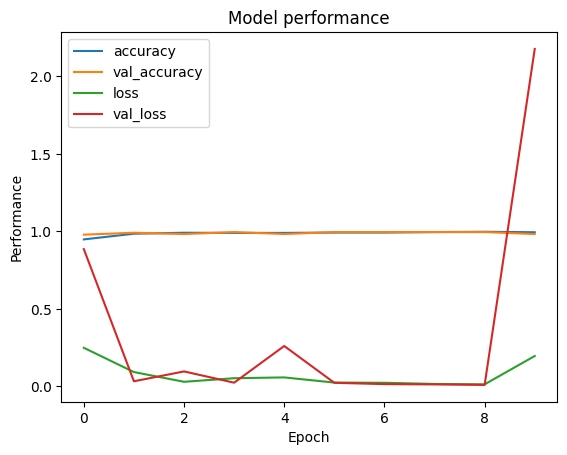

In [ ]:
# Set the seed for reproducibility
np.random.seed(123)
tf.random.set_seed(123)

b2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128,87,1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

b2.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

history = b2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

# Plot the accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model performance')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.legend()
plt.show()

In [ ]:
train_loss, train_acc = b2.evaluate(X_train, y_train)
print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

30/30 [==============================] - 3s 104ms/step - loss: 0.1275 - accuracy: 0.9937
Train loss: 0.12752506136894226, Train accuracy: 0.993697464466095


In [ ]:
test_loss, test_acc = b2.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

8/8 [==============================] - 1s 103ms/step - loss: 2.1778 - accuracy: 0.9833
Test loss: 2.177828788757324, Test accuracy: 0.9832636117935181


# MULTI-CLASS CLASSIFICATION
**12 SPECIES**
- amecro, barswa, bkcchi, blujay, daejun, houfin, mallar3, norfli, rewbla, stejay, wesmea, whcspa

## Data Preprocessing

In [ ]:
# Define the folder path where the bird audio files are stored
folder_path = 'original_clips/'
# Define the new sample rate to which the audio will be resampled
new_sample_rate = 22050
# Define the minimum length (in seconds) of a "loud" part of the sound clip
min_loud_part_length = 0.5
# Define the window size (in seconds) for selecting bird calls
bird_call_window_size = 2
# Define the spectrogram parameters
n_fft = 2048
hop_length = 512
# Initialize the lists for storing the spectrograms and bird names
audios = []
labels = []
# Loop through each bird folder
for bird_folder in os.listdir(folder_path):
  # Get the full path of the bird folder
  bird_folder_path = os.path.join(folder_path, bird_folder)
  # Loop through each audio clip in the bird folder
  for audio_file in os.listdir(bird_folder_path):
    # Get the full path of the audio file
    audio_file_path = os.path.join(bird_folder_path, audio_file)
    # Load the audio file and resample to the new sample rate
    y, sr = librosa.load(audio_file_path, sr=new_sample_rate)
    # Compute the energy of the audio signal
    energy = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)
    # Find the indexes of the "loud" parts of the sound clip
    loud_indexes = np.where(energy > np.max(energy)*0.5)[1]
    # Loop through each "loud" part of the sound clip
    for loud_idx in loud_indexes:
      # Compute the start and end times of the bird call window
      start_time = loud_idx*hop_length/sr
      end_time = start_time + bird_call_window_size
      # Extract the audio signal within the bird call window
      bird_call_audio = y[int(start_time*sr):int(end_time*sr)]
      # Compute the spectrogram of the bird call audio
      spectrogram = librosa.feature.melspectrogram(y=bird_call_audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
      # Add the spectrogram to the list of audios
      audios.append(spectrogram)
      # Add the bird name to the list of labels
      labels.append(bird_folder)
      # Uncomment the following lines to display the spectrograms
      # plt.figure(figsize=(10, 4))
      # librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max),
      #                          y_axis='mel', x_axis='time')
      # plt.colorbar(format='%+2.0f dB')
      # plt.title('Mel spectrogram')
      # plt.tight_layout()
      # plt.show()

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1536
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1792
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1281
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=768
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:2

In [ ]:
# Pad the spectrograms with zeros to ensure they all have the same shape
max_length = max([s.shape[1] for s in audios])
padded_audios = []
for s in audios:
  pad_width = max_length - s.shape[1]
  s_padded = np.pad(s, pad_width=((0, 0), (0, pad_width)), mode='constant')
  padded_audios.append(s_padded)

# Convert the padded audios to a numpy array
audios = np.array(padded_audios)

# Prepare the labels
label_map = {bird_species: i for i, bird_species in enumerate(np.unique(labels))}
labels = np.array([label_map[label] for label in labels])

num_classes = 12
labels = to_categorical(labels, num_classes=num_classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(audios, labels, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6458, 128, 87) (1615, 128, 87) (6458, 12) (1615, 12)


In [ ]:
# Invert the label_map dictionary
num_to_label = {v: k for k, v in label_map.items()}

# Print the numerical label and corresponding bird species for each label
for i in range(num_classes):
    print(f"{i}: {num_to_label[i]}")

0: amecro
1: barswa
2: bkcchi
3: blujay
4: daejun
5: houfin
6: mallar3
7: norfli
8: rewbla
9: stejay
10: wesmea
11: whcspa


## Model 1

In [ ]:
# Set the seed for reproducibility
np.random.seed(123)
tf.random.set_seed(123)

model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128,87,1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])

model1.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])

history = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size = 512)

Epoch 1/10
13/13 [==============================] - 113s 8s/step - loss: 1.9816 - accuracy: 0.5418 - val_loss: 1.2439 - val_accuracy: 0.6508
Epoch 2/10
13/13 [==============================] - 105s 8s/step - loss: 0.9656 - accuracy: 0.7089 - val_loss: 0.8363 - val_accuracy: 0.7090
Epoch 3/10
13/13 [==============================] - 109s 8s/step - loss: 0.6803 - accuracy: 0.7759 - val_loss: 0.6737 - val_accuracy: 0.8087
Epoch 4/10
13/13 [==============================] - 108s 8s/step - loss: 0.5404 - accuracy: 0.8236 - val_loss: 0.5535 - val_accuracy: 0.8359
Epoch 5/10
13/13 [==============================] - 107s 8s/step - loss: 0.4525 - accuracy: 0.8642 - val_loss: 0.5133 - val_accuracy: 0.8489
Epoch 6/10
13/13 [==============================] - 112s 9s/step - loss: 0.4005 - accuracy: 0.8894 - val_loss: 0.5562 - val_accuracy: 0.8613
Epoch 7/10
13/13 [==============================] - 104s 8s/step - loss: 0.3616 - accuracy: 0.8945 - val_loss: 0.4169 - val_accuracy: 0.8817
Epoch 8/10
13

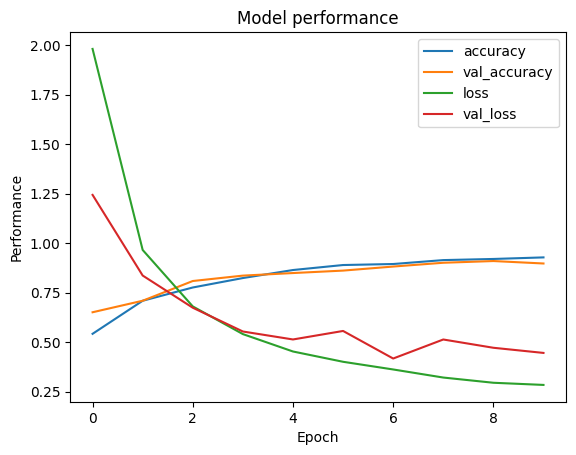

In [ ]:
# Plot the accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model performance')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.legend()
plt.show()

In [ ]:
train_loss, train_acc = model1.evaluate(X_train, y_train)
print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

202/202 [==============================] - 24s 120ms/step - loss: 0.2487 - accuracy: 0.9254
Train loss: 0.24874523282051086, Train accuracy: 0.9253638982772827


In [ ]:
test_loss, test_acc = model1.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

51/51 [==============================] - 6s 120ms/step - loss: 0.4453 - accuracy: 0.8972
Test loss: 0.4452632665634155, Test accuracy: 0.8972136378288269


51/51 [==============================] - 9s 178ms/step


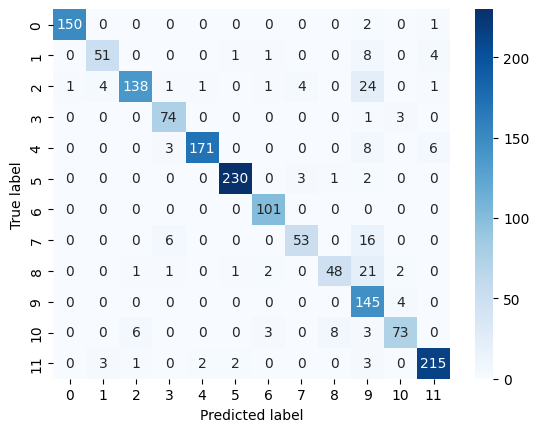

In [ ]:
# Get predictions for test set
y_pred = model1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true classes for test set
y_true = np.argmax(y_test, axis=1)

# Create confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

# Plot heatmap
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## Model2
Using dropout

In [ ]:
# Set the seed for reproducibility
np.random.seed(123)
tf.random.set_seed(123)

model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128,87,1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(12, activation='softmax')
])

model2.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])

history2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size = 512)

Epoch 1/10
13/13 [==============================] - 113s 9s/step - loss: 2.9177 - accuracy: 0.5207 - val_loss: 1.2759 - val_accuracy: 0.6334
Epoch 2/10
13/13 [==============================] - 106s 8s/step - loss: 1.0705 - accuracy: 0.6646 - val_loss: 0.8887 - val_accuracy: 0.7121
Epoch 3/10
13/13 [==============================] - 104s 8s/step - loss: 0.8020 - accuracy: 0.7372 - val_loss: 0.7622 - val_accuracy: 0.7399
Epoch 4/10
13/13 [==============================] - 109s 9s/step - loss: 0.6690 - accuracy: 0.7801 - val_loss: 0.6324 - val_accuracy: 0.7789
Epoch 5/10
13/13 [==============================] - 109s 8s/step - loss: 0.5761 - accuracy: 0.8137 - val_loss: 0.5669 - val_accuracy: 0.8254
Epoch 6/10
13/13 [==============================] - 108s 8s/step - loss: 0.5049 - accuracy: 0.8374 - val_loss: 0.5081 - val_accuracy: 0.8452
Epoch 7/10
13/13 [==============================] - 113s 9s/step - loss: 0.4734 - accuracy: 0.8571 - val_loss: 0.4785 - val_accuracy: 0.8749
Epoch 8/10
13

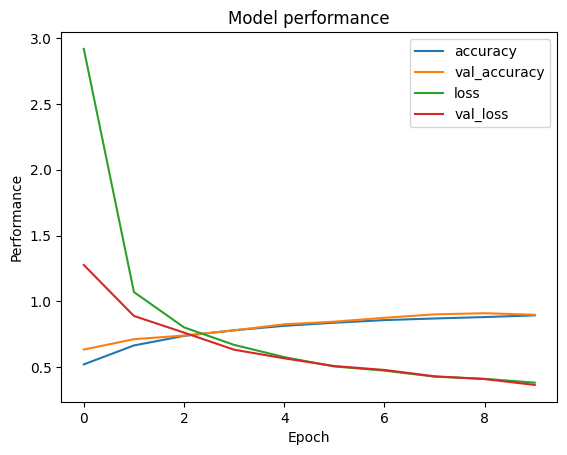

In [ ]:
# Plot the accuracy and loss
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.title('Model performance')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.legend()
plt.show()

In [ ]:
train_loss, train_acc = model2.evaluate(X_train, y_train)
print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

202/202 [==============================] - 28s 138ms/step - loss: 0.2894 - accuracy: 0.9224
Train loss: 0.2894158363342285, Train accuracy: 0.9224218130111694


In [ ]:
test_loss, test_acc = model2.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

51/51 [==============================] - 6s 127ms/step - loss: 0.3647 - accuracy: 0.8978
Test loss: 0.3647180497646332, Test accuracy: 0.8978328108787537


51/51 [==============================] - 6s 112ms/step


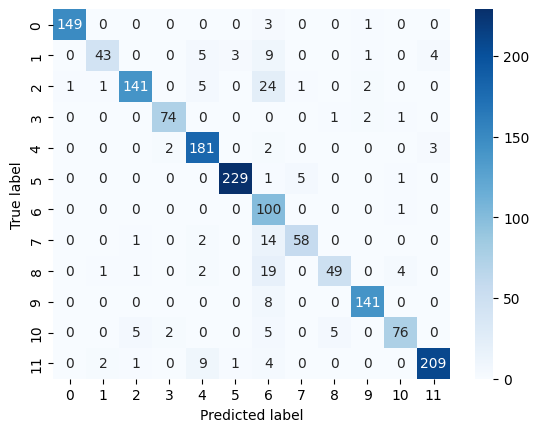

In [ ]:
# Get predictions for test set
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true classes for test set
y_true = np.argmax(y_test, axis=1)

# Create confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

# Plot heatmap
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

0: amecro
1: barswa
2: bkcchi
3: blujay
4: daejun
5: houfin
6: mallar3
7: norfli
8: rewbla
9: stejay
10: wesmea
11: whcspa

In [ ]:
audio_recording="original_clips/bkcchi/XC513209.mp3"
data1,rate1=librosa.load(audio_recording)

audio_recording="original_clips/mallar3/XC440476.mp3"
data2,rate2=librosa.load(audio_recording)

audio_recording="original_clips/rewbla/XC470007.mp3"
data3,rate3=librosa.load(audio_recording)

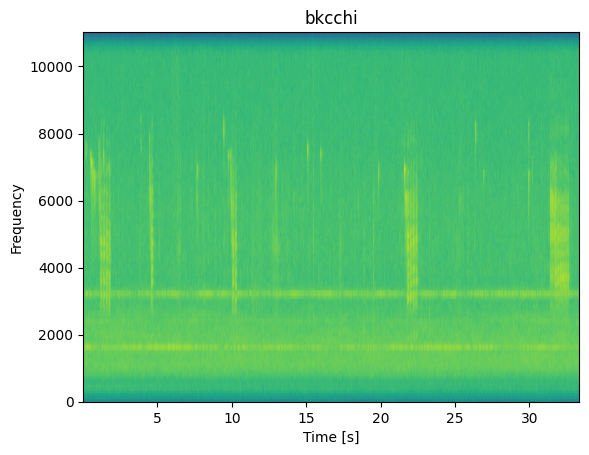

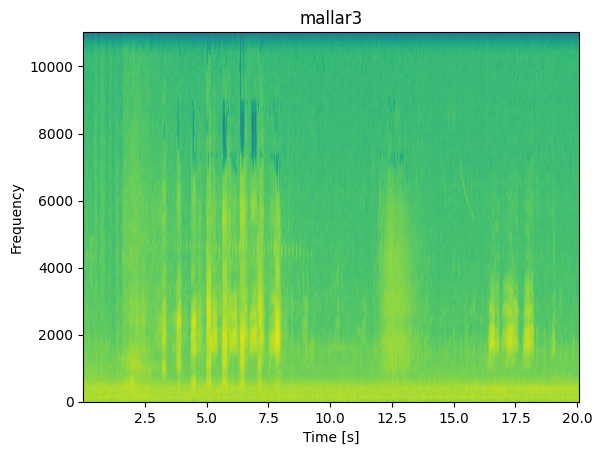

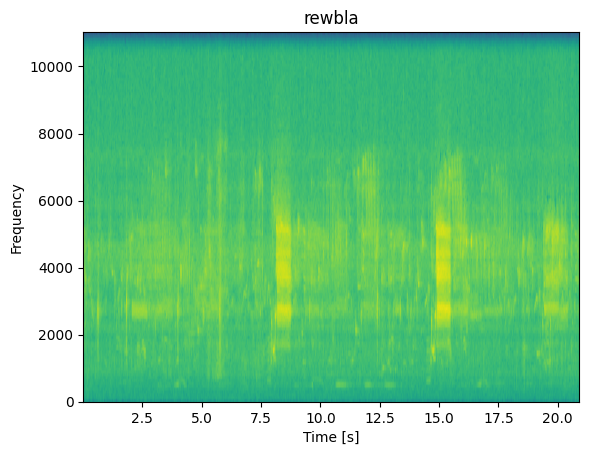

In [ ]:
plt.specgram(data1, Fs=rate1)
plt.xlabel("Time [s]")
plt.ylabel("Frequency");
plt.title('bkcchi')
plt.show()

plt.specgram(data2, Fs=rate2)
plt.xlabel("Time [s]")
plt.ylabel("Frequency");
plt.title('mallar3')
plt.show()

plt.specgram(data3, Fs=rate3)
plt.xlabel("Time [s]")
plt.ylabel("Frequency");
plt.title('rewbla')
plt.show()

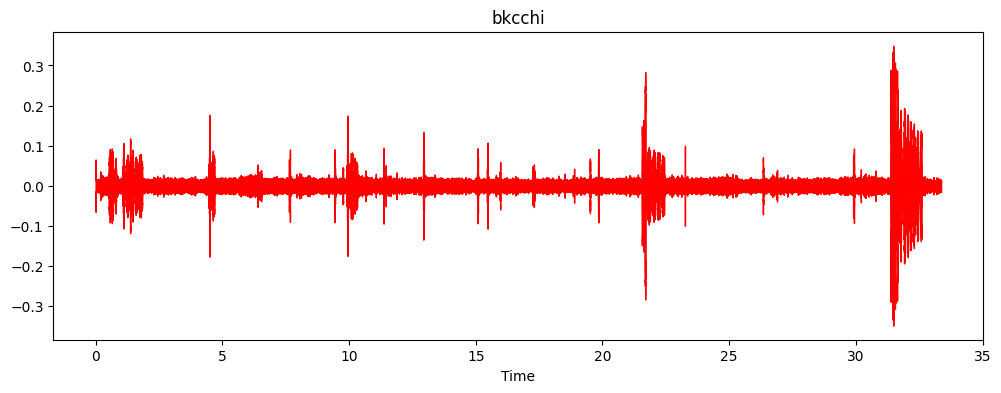

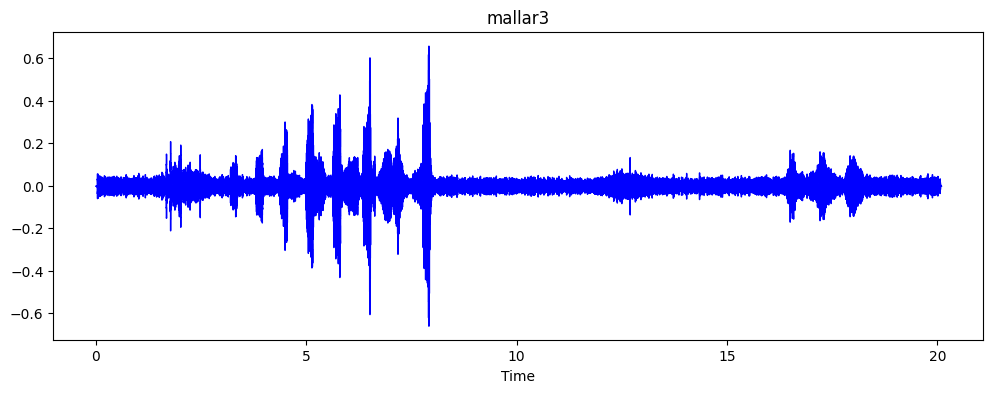

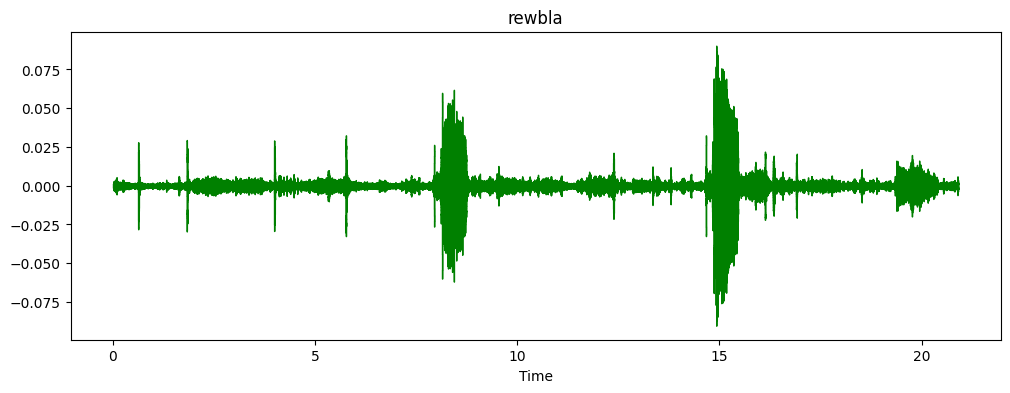

In [ ]:
plt.figure(figsize=(12,4))
librosa.display.waveshow(data1,color="red")
plt.title('bkcchi')
plt.show()

plt.figure(figsize=(12,4))
librosa.display.waveshow(data2,color="blue")
plt.title('mallar3')
plt.show()

plt.figure(figsize=(12,4))
librosa.display.waveshow(data3,color="green")
plt.title('rewbla')
plt.show()

# Transfer Learning

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from skimage.transform import resize

# Load the pre-trained VGG16 model without the top layer
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 87, 3))

# Freeze the layers in the pre-trained model
for layer in vgg_model.layers:
    layer.trainable = False

# Add a new top layer for our audio classification task
flatten_layer = Flatten()(vgg_model.output)
dense_layer1 = Dense(128, activation='relu')(flatten_layer)
dense_layer2 = Dense(num_classes, activation='softmax')(dense_layer1)

# Create the new model
model = Model(inputs=vgg_model.input, outputs=dense_layer2)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Resize the data to add a channel dimension
X_train_resized = []
for sample in X_train:
    resized_sample = resize(sample, (128, 87, 3))
    X_train_resized.append(resized_sample)
X_train_resized = np.array(X_train_resized)

X_test_resized = []
for sample in X_test:
    resized_sample = resize(sample, (128, 87, 3))
    X_test_resized.append(resized_sample)
X_test_resized = np.array(X_test_resized)


# train the model with the generator
model.fit(X_train_resized,y_train,epochs=10, validation_data=(X_test_resized, y_test), batch_size = 512)

# Evaluate the model
score = model.evaluate(X_test_resized, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
13/13 [==============================] - 934s 73s/step - loss: 3.4586 - accuracy: 0.4720 - val_loss: 2.2949 - val_accuracy: 0.5981
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 1.3448 - accuracy: 0.6734 

In [ ]:
#@title
score = model.evaluate(X_train_resized, y_train)
print('Train loss:', score[0])
print('Train accuracy:', score[1])